<a href="https://colab.research.google.com/github/paintedpotato/MI/blob/main/THEONE_11_2_23Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original code developed **from**

https://medium.com/analytics-vidhya/ml-classification-algorithms-to-predict-market-movements-and-backtesting-2382fdaf7a32

In [31]:
!pip install yfinance
!pip install pyfolio
!pip install backtrader
!pip install compressive_transformer_pytorch

# remove your installed pyfolio library
# !pip uninstall pyfolio (We must remove the buggy pyfolio
# that has not yet been updated in pip)

# Install it again from its github repo
#!pip install git+https://github.com/quantopian/pyfolio

# Also replace line 893 in timeseries.py with:
# valley = underwater.index[np.argmin(underwater)] # end of the period
# in order to solve the same error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
mkdir: cannot create directory ‘images’: File exists


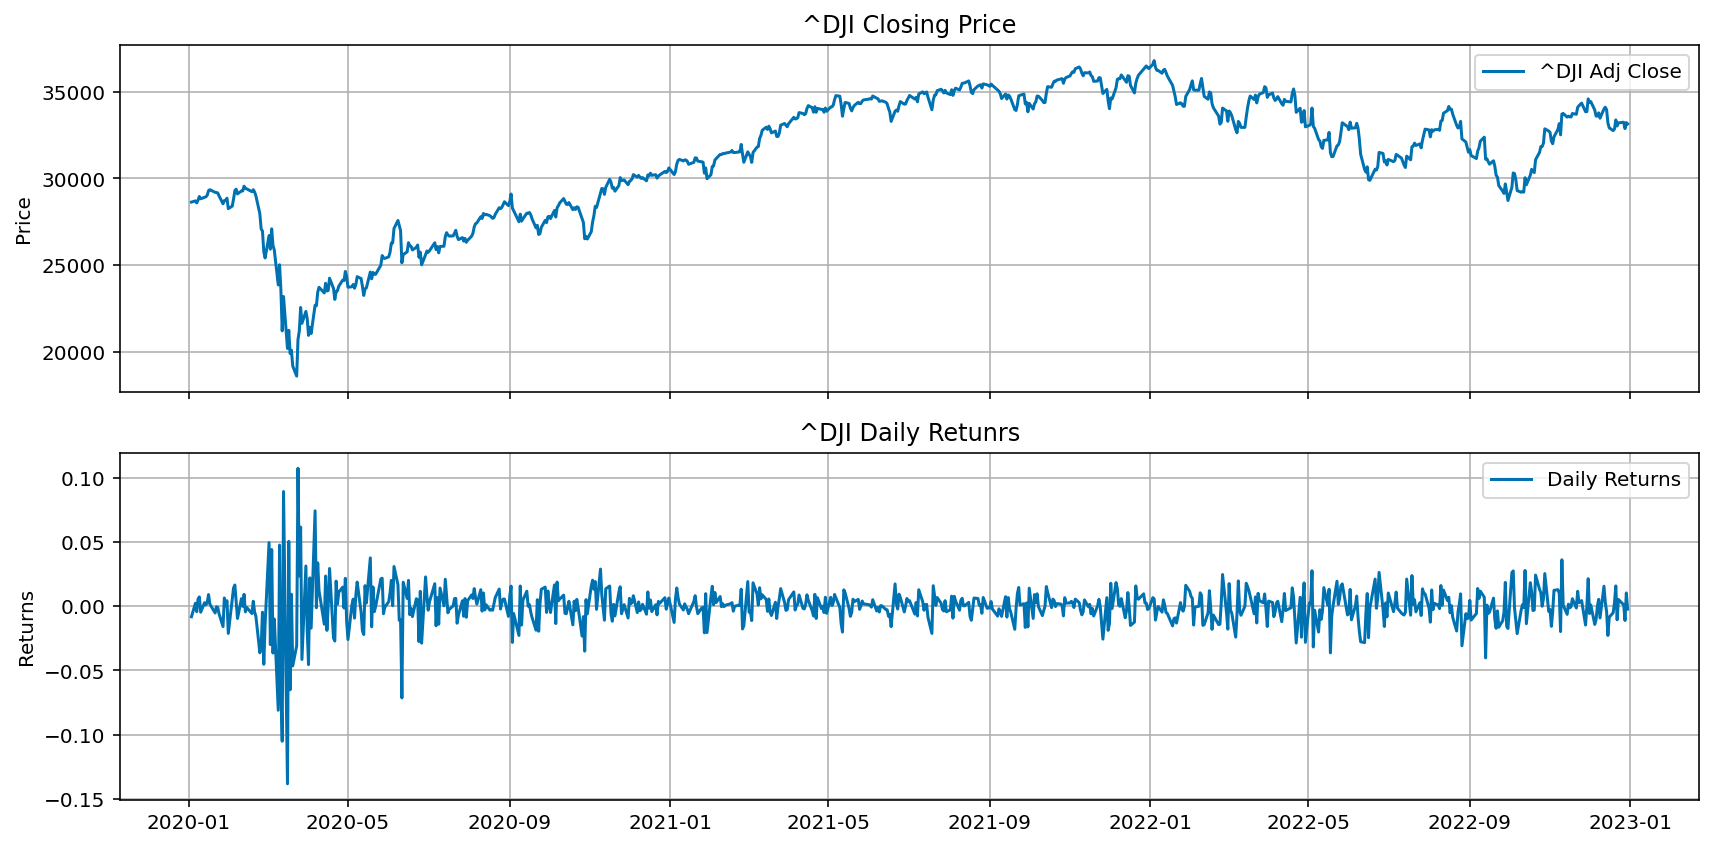

In [32]:
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import datetime
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData
import warnings
import torch

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from compressive_transformer_pytorch import CompressiveTransformer


# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
# this is to display images in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# ticker and the start and end dates for testing
ticker =  '^DJI' # DowJones Industrial average benchmark a.k.a. US30
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2023, 1, 1)
# download ticker ‘Adj Close’ price from yahoo finance
stock =  yf.download(ticker, progress=True, actions=True,start=start, end=end)['Adj Close']
stock2 = yf.download(ticker, progress=True, actions=True,start=start, end=end)
stock = pd.DataFrame(stock)
stock1 = stock
stock.rename(columns = {'Adj Close':ticker}, inplace=True)
stock.head(2)
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head(3)
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock[ticker], label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()
ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()
plt.tight_layout();

!mkdir images
plt.savefig('images/chart1', dpi=300)
# or plt.savefig('/content/drive/MyDrive/Colab Notebooks/images/chart1', dpi=300)


# Compressive Transformer

In [33]:
# Select the Close and Volume columns as input features
data = stock2
X = data[['Close', 'Volume']]

# Create a binary label for whether the price increased or decreased
y = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)

In [34]:
import torch
from compressive_transformer_pytorch import CompressiveTransformer

model = CompressiveTransformer(
    num_tokens = 20000,
    emb_dim = 128,                 # embedding dimensions, embedding factorization from Albert paper
    dim = 512,
    depth = 12,
    seq_len = 1024,
    mem_len = 1024,                # memory length
    cmem_len = 1024 // 4,          # compressed memory buffer length
    cmem_ratio = 4,                # compressed memory ratio, 4 was recommended in paper
    reconstruction_loss_weight = 1,# weight to place on compressed memory reconstruction loss
    attn_dropout = 0.1,            # dropout post-attention
    ff_dropout = 0.1,              # dropout in feedforward
    attn_layer_dropout = 0.1,      # dropout for attention layer output
    gru_gated_residual = True,     # whether to gate the residual intersection, from 'Stabilizing Transformer for RL' paper
    mogrify_gru = False,           # experimental feature that adds a mogrifier for the update and residual before gating by the GRU
    memory_layers = range(6, 13),  # specify which layers to use long-range memory, from 'Do Transformers Need LR Memory' paper
    ff_glu = True                  # use GLU variant for feedforward
)

inputs = torch.randint(0, 256, (1, 2048))
masks = torch.ones_like(inputs).bool()

segments = inputs.reshape(1, -1, 1024).transpose(0, 1)
masks = masks.reshape(1, -1, 1024).transpose(0, 1)

logits, memories, aux_loss = model(segments[0], mask = masks[0])
logits,        _, aux_loss = model(segments[1], mask = masks[1], memories = memories)

# memories is a named tuple that contains the memory (mem) and the compressed memory (cmem)

In [35]:
# Create a transformer to apply the CompressiveTransformer to the input data
# transformer = ColumnTransformer(
#    [('compressive', CompressiveTransformer(), [0, 1])],
#    remainder='passthrough'
#)

In [36]:
# Create a classifier
#classifier = RandomForestClassifier()

# Create a pipeline
#pipeline = Pipeline([('transformer', transformer), ('classifier', classifier)])
# Train the model on the training data:
#pipeline.fit(X, y)


In [37]:
# Make a prediction on the last day of data
#last_day = np.array([X.tail(1)]).reshape(1, -1)
#prediction = pipeline.predict(last_day)[0]

# If the prediction is 1, buy BTC. If the prediction is 0, sell BTC.
#if prediction == 1:
#    print("Buy BTC")
#else:
#    print("Sell BTC")


# Dow Jones Index/US30

In [38]:
# define the number of lags
lags = [1, 2, 3, 4, 5]
# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)
stock.dropna(inplace=True)
stock.head(2)
# function to transform the lag returns to binary values (0,+1)
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)
create_bins(stock)
stock[cols+cols_bin].head(2)


,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rtn_lag1_bin,rtn_lag2_bin,rtn_lag3_bin,rtn_lag4_bin,rtn_lag5_bin
Date,,,,,,,,,,
2020-01-10,0.007342,0.005631,-0.004179,0.002389,-0.008136,1,1,0,1,0
2020-01-13,-0.004608,0.007342,0.005631,-0.004179,0.002389,0,1,1,0,1



Total Returns: 

returns                   1.144710
strategy_log_regs         1.133346
strategy_gauss_nb         1.133346
strategy_svm              1.380460
strategy_random_forest    2.104863
strategy_MLP              1.843181
dtype: float64

Annual Volitility:
Number of trades SVM =  289
Number of trades Ramdom Forest =  337


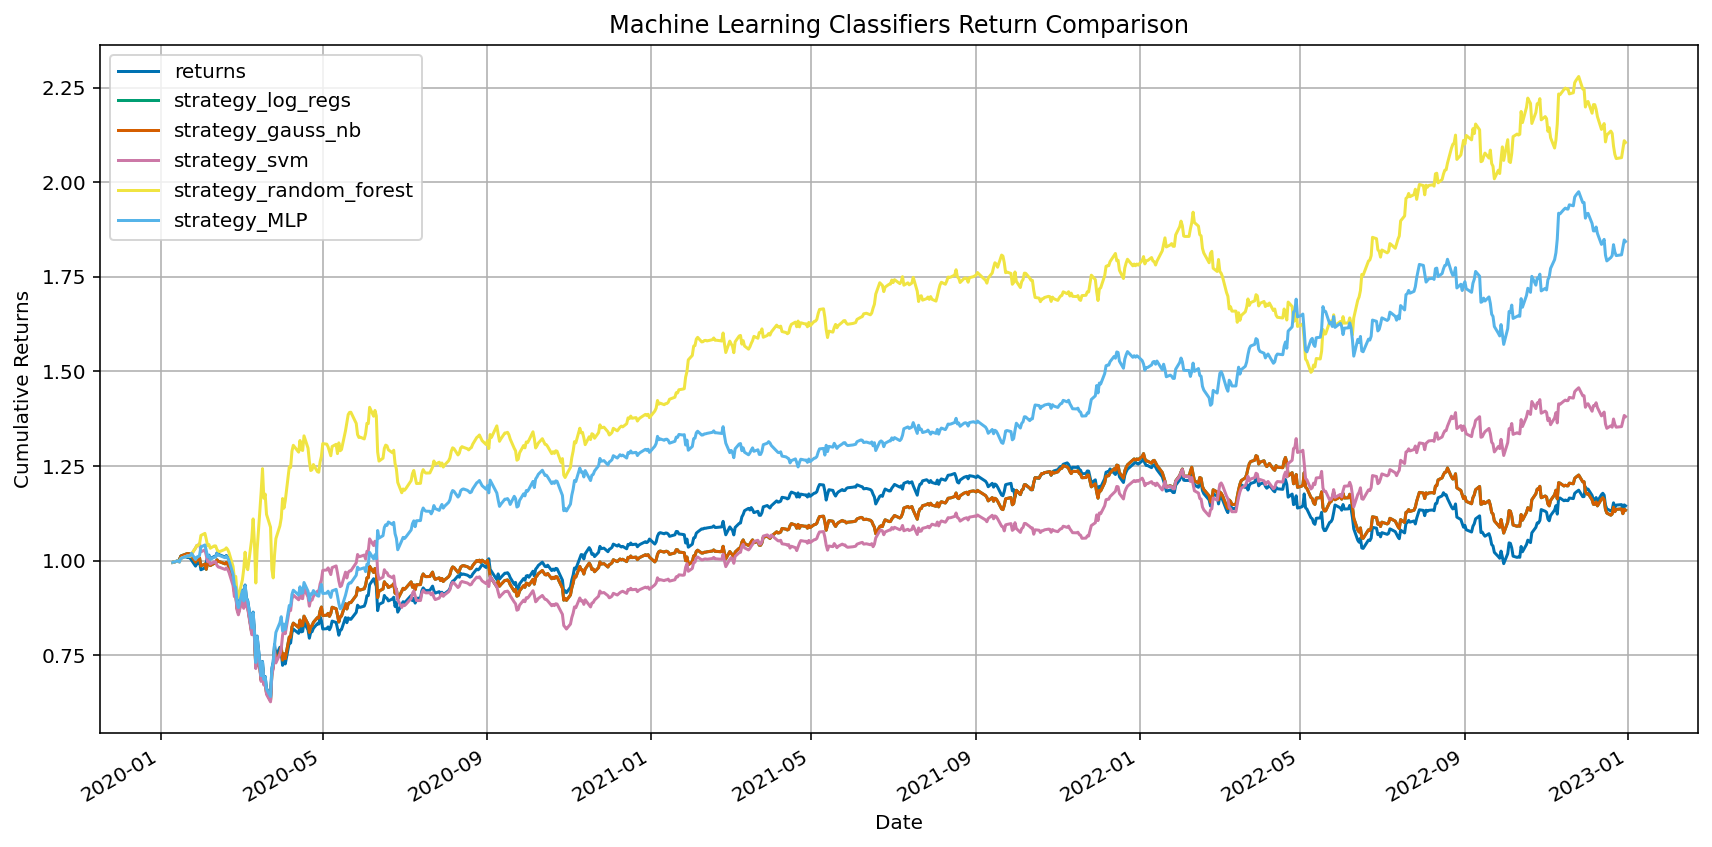

In [39]:
# create a dictionary of selected algorithms
models = {
 'log_regs': linear_model.LogisticRegression(),
 'gauss_nb': GaussianNB(),
 'svm': SVC(),
 'random_forest': RandomForestClassifier(max_depth=10, n_estimators=100),
 'MLP' : MLPClassifier(max_iter=500),
}
# function that fits all models.
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction']) for model in models.keys()}
# function that predicts (derives all position values) from the fitted models
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])
# function to evaluate all trading strategies
def evaluate_strats(data):  
    global strategy_rtn
    strategy_rtn = []
    for model in models.keys():
        col = 'strategy_' + model 
        data[col] = data['pos_' + model] * data['returns']
        strategy_rtn.append(col)
    strategy_rtn.insert(0, 'returns')
# fit the models
fit_models(stock)
# derives all position values
derive_positions(stock)
# evaluate all trading strategies by multiplying predicted directions to actual daily returns
evaluate_strats(stock)
# calculate total return and std. deviation of each strategy
print('\nTotal Returns: \n')
print(stock[strategy_rtn].sum().apply(np.exp))
print('\nAnnual Volitility:')
stock[strategy_rtn].std() * 252 ** 0.5
# number of trades over time for highest and second highest return strategy
print('Number of trades SVM = ', (stock['pos_svm'].diff()!=0).sum())
print('Number of trades Ramdom Forest = ',(stock['pos_random_forest'].diff()!=0).sum())
# vectorized backtesting of the resulting trading strategies and visualize the performance over time
ax = stock[strategy_rtn].cumsum().apply(np.exp).plot(figsize=(12, 6), 
                                                     title = 'Machine Learning Classifiers Return Comparison')
ax.set_ylabel("Cumulative Returns")
ax.grid(True);
plt.tight_layout();
plt.savefig('images/chart2', dpi=300)

In [40]:
# fetch the daily pricing data from yahoo finance
prices = yf.download(ticker, progress=True, actions=True, start=start, end=end)
prices.head(2)
# rename the columns as needed for Backtrader
prices.drop(['Close','Dividends','Stock Splits'], inplace=True, axis=1)
prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',
                         }, inplace=True)
prices.head(3)
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
predictions = stock['strategy_svm']
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'strategy_svm':'predicted'}, inplace=True)
prices = predictions.join(prices, how='right').dropna()
prices.head(2)
OHLCV = ['open', 'high', 'low', 'close', 'volume']
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']
# create lines
    lines = tuple(cols)
# define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())


[*********************100%***********************]  1 of 1 completed


In [41]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')
        # set no pending order
        self.order = None
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_predicted < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)


In [42]:
# instantiate SignalData class
data = SignalData(dataname=prices)
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2020-01-13, BUY CREATED --- Size: 3, Cash: 100000.00, Open: 28869.009765625, Close: 28907.05078125
2020-01-13, BUY EXECUTED --- Price: 28869.01, Cost: 86607.03,Commission: 86.61
2020-01-15, SELL CREATED --- Size: 3
2020-01-15, SELL EXECUTED --- Price: 28901.80, Cost: 86607.03,Commission: 86.71
2020-01-15, OPERATION RESULT --- Gross: 98.37, Net: -74.94
2020-01-16, BUY CREATED --- Size: 3, Cash: 99925.06, Open: 29131.94921875, Close: 29297.640625
2020-01-16, BUY EXECUTED --- Price: 29131.95, Cost: 87395.85,Commission: 87.40
2020-01-22, SELL CREATED --- Size: 3
2020-01-22, SELL EXECUTED --- Price: 29263.63, Cost: 87395.85,Commission: 87.79
2020-01-22, OPERATION RESULT --- Gross: 395.04, Net: 219.86
2020-01-24, BUY CREATED --- Size: 3, Cash: 100144.92, Open: 29230.390625, Close: 28989.73046875
2020-01-24, BUY EXECUTED --- Price: 29230.39, Cost: 87691.17,Commission: 87.69
2020-01-31, SELL CREATED --- Size: 3
2020-01-31, SELL EXECUTED --- Price: 28813.04, 

Start date,2020-01-10
End date,2022-12-30
Total months,35
,Backtest
Annual return,38.639%
Cumulative returns,164.408%
Annual volatility,14.019%
Sharpe ratio,2.40
Calmar ratio,3.94
Stability,0.92
Max drawdown,-9.806%


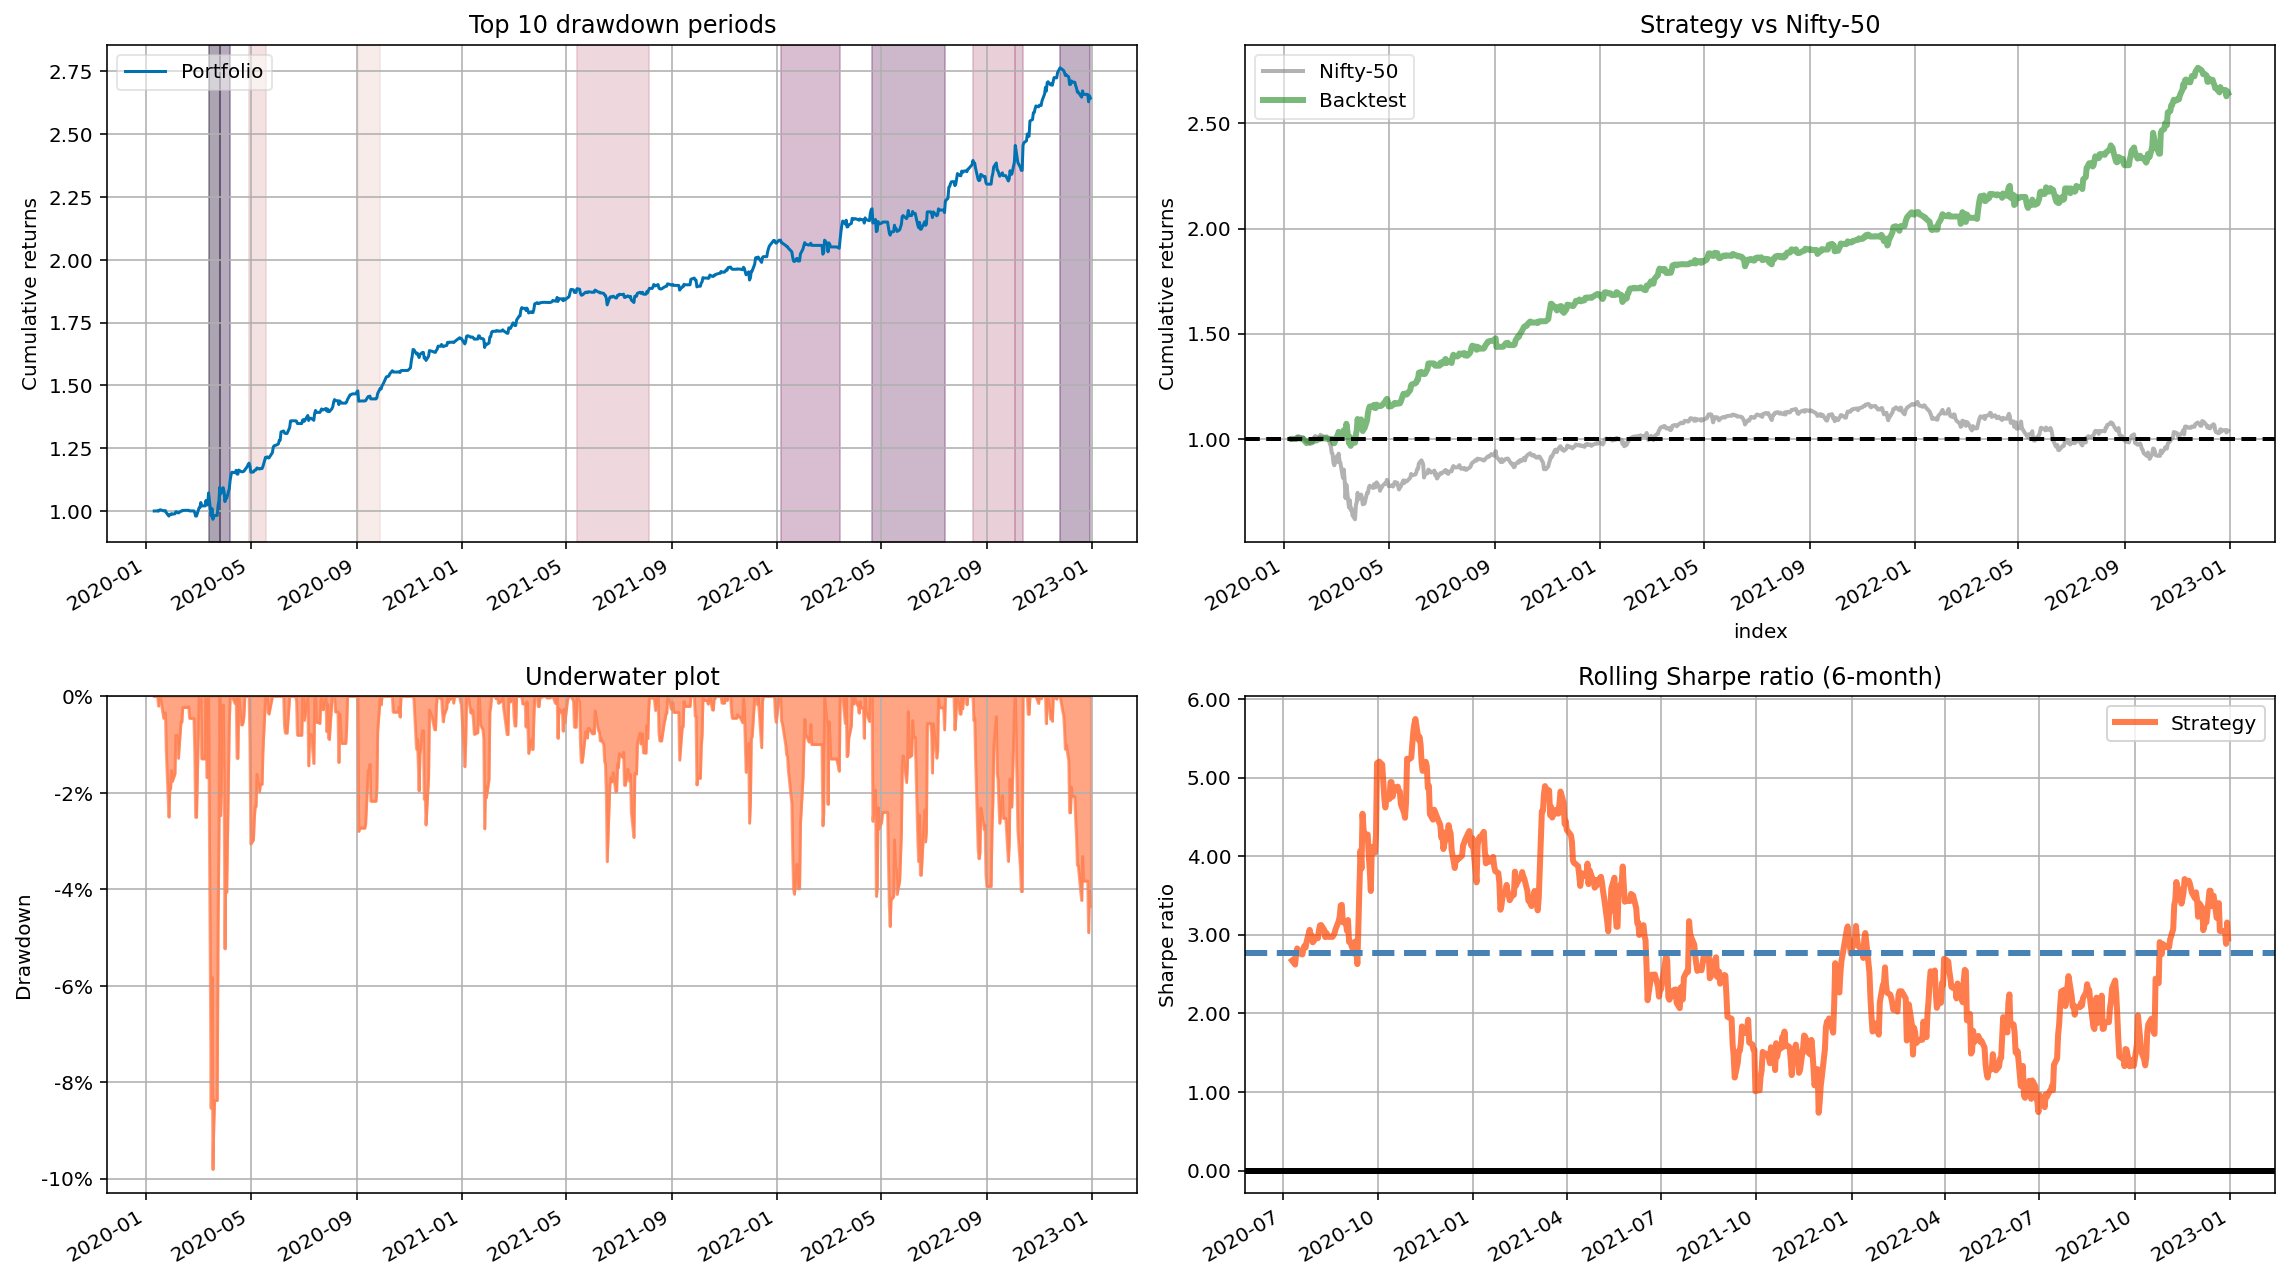

In [43]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(2)
# get benchmark returns
benchmark_rets= stock['returns']
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'Nifty-50'
benchmark_rets.head(2)
# get performance statistics for strategy
pf.show_perf_stats(returns)
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()
pf.plot_drawdown_periods(returns=returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[1], title='Strategy vs Nifty-50')
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
axes[3].grid(True)
# fig.suptitle('Strategy vs Nifty-50 (Buy and Hold)', fontsize=16, y=0.990)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('images/chart3', dpi=300)


My edits

In [44]:
#!pip install pytorch torchvision cudatoolkit=10.1 -c pytorch

In [45]:
from compressive_transformer_pytorch import CompressiveTransformer
from compressive_transformer_pytorch.autoregressive_wrapper import AutoregressiveWrapper

import random
import tqdm
import gzip
import numpy as np
import torch
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

# constants

NUM_BATCHES = int(1e5)
BATCH_SIZE = 16
MAX_BATCH_SIZE = 4
LEARNING_RATE = 1e-4
VALIDATE_EVERY  = 100

GENERATE_EVERY  = 500
PRIME_LENGTH    = 512
GENERATE_LENGTH = 1024

SEQ_LEN = 512
NUM_SEGMENTS = 4

# helpers

def cycle(loader):
    while True:
        for data in loader:
            yield data

def decode_token(token):
    return str(chr(max(32, token)))

def decode_tokens(tokens):
    return ''.join(list(map(decode_token, tokens)))

# instantiate model

model = CompressiveTransformer(
    num_tokens = 256,
    dim = 512,
    depth = 8,
    seq_len = SEQ_LEN,
    mem_len = SEQ_LEN,
    cmem_len = SEQ_LEN // 4,
    heads = 8,
    memory_layers = [6,7,8]
)

model = AutoregressiveWrapper(model)
model.cuda()

# prepare enwik8 data

#with gzip.open('./data/enwik8.gz') as file:
#    X = np.fromstring(file.read(int(95e6)), dtype=np.uint8)
#    trX, vaX = np.split(X, [int(90e6)])
#    data_train, data_val = torch.from_numpy(trX), torch.from_numpy(vaX)
num_rows = len(stock.index)
trX = stock.iloc[:, 0:(num_rows*.8)]
vaX = stock.iloc[:, ((num_rows*.8)+1):num_rows]
data_train, data_val = torch.from_numpy(trX), torch.from_numpy(vaX)


class TextSamplerDataset(Dataset):
    def __init__(self, data, seq_len, segments):
        super().__init__()
        self.data = data
        self.seq_len = seq_len
        self.segments = segments
        self.total_len = seq_len * segments

    def __getitem__(self, index):
        rand_start = torch.randint(0, self.data.size(0) - self.total_len - 1, (1,))
        full_seq = self.data[rand_start: rand_start + self.total_len + 1].long()
        return full_seq.cuda()

    def __len__(self):
        return self.data.size(0) // self.total_len

train_dataset = TextSamplerDataset(data_train, SEQ_LEN, NUM_SEGMENTS)
val_dataset   = TextSamplerDataset(data_val, SEQ_LEN, NUM_SEGMENTS)
train_loader  = cycle(DataLoader(train_dataset, batch_size = BATCH_SIZE))
val_loader    = cycle(DataLoader(val_dataset, batch_size = BATCH_SIZE))

# optimizer

optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# training

for i in tqdm.tqdm(range(NUM_BATCHES), mininterval=10., desc='training'):
    model.train()

    grad_accum_every = BATCH_SIZE / MAX_BATCH_SIZE

    for mlm_loss, aux_loss, is_last in model(next(train_loader), max_batch_size = MAX_BATCH_SIZE, return_loss = True):
        loss = mlm_loss + aux_loss
        (loss / grad_accum_every).backward()

        print(f'training loss: {mlm_loss.item():.4f} | aux_loss: {aux_loss.item():.4f}')

        if is_last:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optim.step()
            optim.zero_grad()

    if i % VALIDATE_EVERY == 0:
        model.eval()
        with torch.no_grad():
            for loss, aux_loss, _ in model(next(val_loader), return_loss = True):
                print(f'validation loss: {loss.item():.4f}')

    if i % GENERATE_EVERY == 0:
        model.eval()
        inp = random.choice(val_dataset)[:-1]
        inp = inp[:PRIME_LENGTH]
        prime = decode_tokens(inp)
        print(f'%s \n\n %s', (prime, '*' * 100))

        sample = model.generate(inp, GENERATE_LENGTH)
        output_str = decode_tokens(sample)
        print(output_str)

RuntimeError: ignored

In [ ]:
parser.add_argument('--gpu', type=str, default="0", help='choose GPU')
